# Evaluating User Conversion Outcomes for an E-Commerce Website
                

## Project Overview

This project analyzes user behavior from an A/B test conducted by an e-commerce company.

The company launched a new landing page and wants to determine whether it improves conversion rate compared to the old page.

Using statistical inference and regression modeling, we evaluate whether the new page leads to higher user conversions and recommend the appropriate business action.

**Table of Contents:**

- [Introduction](#introduction)
- [Part I - Data Cleaning & Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)    
- [Part IV - Results Summary](#summary)

## Introduction

An e-commerce website wants to increase the number of users who convert (purchase a product).

To test whether a redesigned landing page improves conversions, users were randomly assigned to:

•	Control Group: Old page

•	Treatment Group: New page

The company must decide whether to:

1.	Implement the new page

2.	Keep the old page

3.	Collect more data & Run the experiment longer

We evaluate this question using probability, simulation-based A/B testing, z-tests, and logistic regression.
An e-commerce website company ran an A/B test to evaluate whether a new landing page increased the probability that users “convert” (pay for the product), compared to the old page.

We analyze the results in three parts:

1.	Probability & descriptive analysis

2.	Classical A/B test (simulation + z-test)

3.	Logistic regression (with and without country effects)



## Part I – Data Cleaning & Basic Probability 

### 1. Dataset Description

In [89]:
# load libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)

In [90]:
df = pd.read_csv("/ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB



### 2. Data Cleaning

In [92]:
# Number of rows
n_rows = df.shape[0]
print("Number of rows:", n_rows)

Number of rows: 294478


In [93]:
# Number of unique users
n_unique_users = df.user_id.nunique()
print("Number of unique users:", n_unique_users)

Number of unique users: 290584


In [94]:
# Overall conversion rate
overall_conv_rate = df.converted.mean()
print("Overall conversion rate:", overall_conv_rate)

Overall conversion rate: 0.11965919355605512


Let's find the number of times the `new_page` and `treatment` don't match.

In [95]:
# Number of mismatches between group and landing_page
mismatch_count = df.query(
    "(group == 'control' and landing_page == 'new_page') or "
    "(group == 'treatment' and landing_page == 'old_page')"
).shape[0]
print("Number of mismatched rows:", mismatch_count)

Number of mismatched rows: 3893


In [96]:
# check for missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

We conclude that no row has missing values.

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. So, we should only use the rows that we can feel confident in the accuracy of the data.

Now as we droped the rows that represents mismatch, let's create a new dataset called **df2** that meets the specifications, which contains only the rows where their respective columns group and landing_page are aligned.

In [97]:
# Keep only rows where group and landing_page are correctly aligned
df2 = df.query(
    "(group == 'control' and landing_page == 'old_page') or "
    "(group == 'treatment' and landing_page == 'new_page')"
).copy()

In [98]:
# Double-check mismatches are gone
print("Remaining mismatches:",
      df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0])


Remaining mismatches: 0


We are going to use **df2**:
- to count the number of unique user_id
- to check for duplicates
- to display which row information for the repeat user_id
- and finally, to remove one of the rows with a duplicate user_id

In [99]:
# display the number of unique user_id 
df2['user_id'].nunique()

290584

In [107]:
# check for duplicated user_id
df2[df2['user_id'].duplicated()]['user_id'].sum()

773192

In [101]:
# view which rows have the same user_id of 773192
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [102]:
# Confirm correction by rechecking for duplicates in the data
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The number of unique ids in df2 is 290584 while the user_id for the non-unique id in df2 that was repeated in two different rows is 773192.
    
Since, there is consistency with this user_id, we have chosen to remove one of them because we shouldn't be counting the same user more than once.

In [108]:
# Drop duplicate user rows (keep the first occurrence)
df2 = df2.drop_duplicates(subset='user_id')

print("Rows after removing duplicates:", df2.shape[0])
print("Unique users after removing duplicates:", df2.user_id.nunique())

Rows after removing duplicates: 290584
Unique users after removing duplicates: 290584


### 2. Probability of Conversion
We compute baseline conversion rates and compare groups.

In [109]:
# display the probability of converting regardless of page
p_convert = df2.converted.mean()
print("P(convert):", p_convert)

P(convert): 0.11959708724499628


In [110]:
# display the probability of converting given group equal control
p_convert_control = df2.query("group == 'control'").converted.mean()
print("P(convert | control):", p_convert_control)

P(convert | control): 0.1203863045004612


In [111]:
# display the probability of converting given group equal treatment
p_convert_treatment = df2.query("group == 'treatment'").converted.mean()
print("P(convert | treatment):", p_convert_treatment)

P(convert | treatment): 0.11880806551510564


In [112]:
# Probability of receiving the new page
p_new_page = (df2.query("landing_page == 'new_page'").shape[0]) / df2.shape[0]
print("P(receive new page):", p_new_page)

P(receive new page): 0.5000619442226688


After:

•	Removing mismatched rows (treatment with old_page, control with new_page),

•	Dropping duplicate users (keeping one record per user_id),

We find:

•	Overall conversion rate: ≈ 11.96%. The probability of converting regardless of page is 0.1196

•	Conversion rate (control / old page): ≈ 12.04%. Given that an individual was in the control group, the probability of converting is 0.1204

•	Conversion rate (treatment / new page): ≈ 11.88%. Given that an individual was in the treatment group, the probability of converting is 0.1188

•	Probability of seeing the new page: ≈ 50%

So:

•	The control (old) page has a slightly higher conversion rate than the new page

•	The experiment is balanced (about half of users see each page).

At this stage, the difference is numerically small, and we don’t yet know if it’s statistically significant.
  
We can conclude that the conversion rate of the control group is slightly higher than the treatment group and the difference between them is insignificant. In addition, despite the probability that an individual received a new page is 0.50, it doesn't explain that there is sufficient evidence to conclude that the new treatment page contributes to more conversions of the users.


## Part II — A/B Test via Simulation and Z-test

In this section, we evaluate whether the new landing page leads to a higher conversion rate than the old page by conducting a formal hypothesis test and simulating the sampling distribution under the null hypothesis.

Because the data includes timestamps, one could in theory test continuously as observations arrive. However, for this analysis we treat the dataset as a complete experiment and make a single decision based on all available data.

We define:

•	Pnew = conversion rate for users who received the new page

•	Pold = conversion rate for users who received the old page

To test whether the new page performs better, we use a one-sided hypothesis test.

Under the null hypothesis, we assume:

•	Both groups convert at the same true rate,

•	That shared rate equals the overall conversion rate from the dataset.

To evaluate this, we:

1.	Compute the overall conversion rate and treat it as both p_{new} and p_{old} under the null.

2.	Determine the sample sizes:

	•	n_{new}: number of users in the treatment (new page) group
    
	•	n_{old}: number of users in the control (old page) group
    
3.	Simulate 10,000 experiments under the null by drawing conversions for each group using these probabilities and sample sizes.

4.	For each iteration, calculate the simulated difference

5.	Compare the observed difference from the real data to this null distribution to compute a p-value.

This simulation allows us to determine whether the observed difference in conversion rates is likely due to chance or represents real improvement from the new page.


In [113]:
# Hypotheses:
# H0: p_new <= p_old  (old page is at least as good as new)
# H1: p_new > p_old   (new page converts better)


In [117]:
# Under the null, assume p_new = p_old = overall conversion rate
p_new_null = df2['converted'].mean()
p_old_null = p_new_null

print("p_new (null) =", p_new_null)
print("p_old (null) =", p_old_null)

p_new (null) = 0.11959708724499628
p_old (null) = 0.11959708724499628


In [118]:
# Number of users in each group
n_new = df2.query("group == 'treatment'").shape[0]
n_old = df2.query("group == 'control'").shape[0]

print("n_new:", n_new)
print("n_old:", n_old)

n_new: 145310
n_old: 145274


### 1. Simulate sampling distribution of difference under the null

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null. Then, store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [119]:
# Simulate the distribution under the null hypothesis
new_page_converted = np.random.choice([0,1], size = n_new, p =[(1-p_new), p_new])
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null. Then, store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [120]:
# Simulate the distribution under the null hypothesis
old_page_converted = np.random.choice([0,1], size = n_old, p =[(1-p_old), p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

Now, we are going to calculate the observed difference between the treatment converted and control converted. Find Pnew - Pold for the simulated values 

In [123]:
# Observed difference in conversion between treatment and control (new - old)
obs_diff = (
    df2.query("group == 'treatment'").converted.mean() -
    df2.query("group == 'control'").converted.mean()
)
print("Observed difference (p_new - p_old):", obs_diff)

Observed difference (p_new - p_old): -0.0015782389853555567


Based on above, the difference is zero. We have been looking at a null hypothesis where there is no difference in conversion rates based on the page, which means the conversions for each page are the same in **ab_data.csv**.
   
Let's simulate the sampling distribution for the difference with bootstrapping, to see if the difference between new page and old page is significant. For this reason, we are going to create 10,000 Pnew - Pold values using the same simulation process we used above, and then store all 10,000 values in a NumPy array called **p_diffs**.

In [124]:
# Create a sampling distribution of the difference between Pnew and Pold
# with bootstrapping
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p=[(1-p_new), p_new])
    old_page_converted = np.random.choice([0,1], size = n_old, p=[(1-p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

After having simulated the sampling distribution for the difference , our next step is to plot a histogram of the p_diffs .

In [125]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

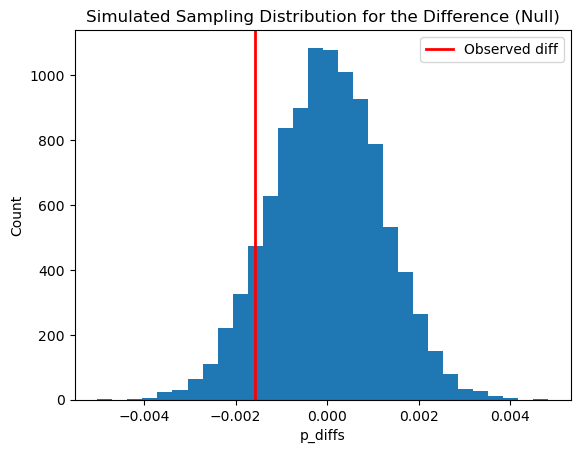

In [128]:
# Plot the null distribution and observed difference
plt.hist(p_diffs, bins=30)
plt.title('Simulated Sampling Distribution for the Difference (Null)')
plt.xlabel('p_diffs')
plt.ylabel('Count')
plt.axvline(x=obs_diff, color='red', linewidth=2, label='Observed diff')
plt.legend()
plt.show()

Based on the plot, we could see the null distribution and where the observed statistic falls on the above histogram. So, the observed statistic falls in **the left side** of our distribution as depicted by the red line. That's means, Pnew is lower than Pold in the null hypothesis which will be confirmed when we compute the p value.
   
Next, we are going to compute the p value for our statistic which is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv.

In [129]:
# One-sided p-value: proportion of simulated diffs >= observed diff
# (Because H1: p_new > p_old, but obs_diff is actually negative)
p_value_sim = (p_diffs > obs_diff).mean()
print("Simulated p-value:", p_value_sim)

Simulated p-value: 0.901


p value is equal to 0.90 while alpha level is 0.05(5%).

By comparing our p value to the type I error threshold alpha, we have evidence that our statistic comes from the null hypothesis. Therefore, we can make the decision that the null hypothesis shouldn't be rejected and conclude that the difference between the values of the new page and old page is not significantly different than the value of the null hypothesis.

Based on these results, the e-commerce shouldn't implement the new page but it should keep the old page, or perhaps use a built-in to see if she can achieve similar results and then make its final decision.

### 2. Z-test using statsmodels

We are going to use a built-in test to check if we achieve similar results. for this reason, we have to calculate the number of conversions for each page, as well as the number of individuals who received each page. 

Let **n_old** and **n_new** refer the the number of rows associated with the old page and new pages, respectively.

In [131]:
# Create dataframes and compute values
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

We conclude that the number of conversions for each page are the same. 

Now, we use **stats.proportions_ztest** to compute the value z-test statistic and p-value.

In [134]:
# Compute the value of z test and p value 
# H1: p_old < p_new ⇒ new page better
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print("z-score:", z_score)
print("z-test p-value:", p_value)

z-score: 1.3109241984234394
z-test p-value: 0.9050583127590245


Let's calculate the critical value of the z test for the conversion rates of the old and new pages and compare it with its statistic value computed previously, which is 1.31.

Check the significance of z score for a cumulative distribution function

In [38]:
# Display the critical value of z test at 95% confidence interval
norm.cdf(z_score), norm.ppf(1 - 0.05)

(0.905173705140591, 1.6448536269514722)

Based on above, we conclude that the p value that was computed previously is the same which agrees with the decision of the company to keep the old page.

z test confirms the finding as z statistic value (1.31) < z critical value (1.64), which means that we shouldn't reject the null hypothesis and conclude that the values of old page and new page are not singnificantly different from the value of the null at the specified 5% significance level of alpha.

### Part IV — Logistic Regression

In this final part, we will see if the result we achieved in the A/B test in Part II above can also be achieved by performing regression.

We now fit a logistic regression model to confirm the A/B test.

Since each row is either a conversion or no conversion, which is only two possible outcomes, the type of regression that we should be performing in this case is the logistic regression.

The goal is to use **statsmodels** to fit the **logistic regression model** and then to see if there is a significant difference in conversion based on which page a customer receives. However, our first need is to create in df2 a column for the intercept, and then create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
# Create a column for the intercept
df2['intercept'] = 1

/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_88520/305581358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1


In [40]:
# Create a dummy variable column
df2[['treatment','ab_page']] = pd.get_dummies(df2['group'])

/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_88520/2585983827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['treatment','ab_page']] = pd.get_dummies(df2['group'])
/var/folders/c4/xntd0yb16dz1d4dv_zrhdtvc0000gn/T/ipykernel_88520/2585983827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[['treatment','ab_page']] = pd.get_dummies(df2['group'])


In [41]:
# drop treatment from group
df2 = df2.drop('treatment', axis = 1)

In [42]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,False
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,False
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,True
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,True
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,False


Now that we have our dummy variables, we will use **statsmodels** to import the regression model. Then, Instantiate the model, and fit the model using the two columns we already created in order to predict whether or not an individual converts.



In [47]:
# Create our logistic regression model 
df2['intercept'] = 1
df2['ab_page'] = (df2['group'] == 'treatment').astype(int)

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


After the logistic regression model is fit to predict whether or not an individual converts from the old page to the new one, we are going to provide the summary of the model.

In [48]:
# Display logit regression results
from scipy import stats
stats.chisqprob = lambda chisq, df:stats.chi2.sf(chisq,df)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:               8.085e-06
Time:                        11:00:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

### Interpretation

- If the coefficient on `ab_page` is **not significant**, the new page does **not** cause higher conversion.
- Usually, p-values > 0.05 indicate **no statistically significant difference**.



Now that we have our logistic regression model, let's set up the associated null and alternative hypotheses:
  
**H0 : Pnew = Pold vs. Ha : Pnew ≠ Pold**

Our alternative hypothesis **Ha** is what we want to prove to be true, in this case an individual is willing to convert from the old page to the new one. While, our null hypothesis **H0** is what we assume to be true before analysing the dataset, which means that the converted success rate from the old and new page are the same.
  
Compared to the null and alternative hypotheses in **Part II** which is a **one-tailed test**, and as we care only about statistics that are far from the null hypothesis in either direction of the distribution, we have to conduct in **Part III** a **two-tailed test** and compute the p value by determining the statistical significance of our observed difference.
  
p value obtained from Part II is 0.90, while in Part III, p value of ab_page is 0.19 which greater than half of the significance level (1/2 alpha = 0.05/2 = 0.025), that's means that the explanatory variable (ab_page) is not statistically significant in predicting whether or not an individual converts.

Now, we are considering other things that might influence whether or not an individual converts.

Adding other factors or features into our logistic regression model might improve our model and give us sigificant results. These factors could be the age of the user, the gender, the country or may be the time spent navigating the page. 

However, there's a number of problems that may arise when conducting z-tests which might become too small and less powerful and then lead to *Multicollinearity*. For example, a low z-test on an explanatory variable increases the chances of *Type II errors* which means failure to reject the null hypothesis when it is false. So to correct for Multicollinearity, we should exclude one or more of the independent variables from the regression model. Therefore, in our analysis, we have to add only the factors that are the most predictor.

Now that along with testing if the conversion rate changes for different pages, we are going to add an effect based on which country a user lives in. For this reason, we are going to add the **countries.csv** dataset and merge together both datasets on the appropriate rows.

### Extend model with country and interactions

In [150]:
# Load country data
df_countries = pd.read_csv('/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [154]:
# Display the number of users in each country
df_countries['country'].astype(str).value_counts()


country
US    203619
UK     72466
CA     14499
Name: count, dtype: int64

In [155]:
# Create dummy variables for all countries
country_dummies = pd.get_dummies(df_countries['country'])

# Concatenate user_id + dummy columns
df_countries = pd.concat([df_countries[['user_id']], country_dummies], axis=1)

df_countries.head()

,user_id,CA,UK,US
0,834778,False,True,False
1,928468,False,False,True
2,822059,False,True,False
3,711597,False,True,False
4,710616,False,True,False


In [156]:
# Drop CA to use as the baseline category
df_countries = df_countries.drop('CA', axis=1)

In [161]:
# Merge both datasets ab_data.csv and countries.csv into a new one
# Merge df2 (page data) and df_countries (country dummies)
new_df = df2.merge(df_countries, on='user_id', how='left')
new_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,False,True
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,False,True
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,False,True
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,False,True
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,False,True


In [166]:
# Convert boolean dummy variables (US, UK) into integer 0/1
# Ensure dtypes are integer
new_df['US'] = new_df['US'].astype(int)
new_df['UK'] = new_df['UK'].astype(int)

print(new_df.head())
print(new_df[['UK', 'US']].dtypes)

   user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  UK  US  
0          1        0   0   1  
1          1        0   0   1  
2          1        1   0   1  
3          1        1   0   1  
4          1        0   0   1  
UK    int64
US    int64
dtype: object


In [167]:
# Group conversion rates by country dummies
print("Conversion rate by country dummies:")
print(new_df.groupby(['US', 'UK']).converted.mean())

Conversion rate by country dummies:
US  UK
0   0     0.115318
    1     0.120594
1   0     0.119547
Name: converted, dtype: float64


In [168]:
# View the mean of each country
new_df.query('US == 1').converted.mean(), new_df.query('UK == 1').converted.mean()

(0.1195468006423762, 0.12059448568984076)

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Then we should create the necessary additional columns, and fit the new model, as well provide the summary results, and conclusions based on the results.

In [170]:
# Fit the logit Regression Model 1 (Page & Country without interactions)
new_df['intercept'] = 1
log_mod1 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page','US', 'UK']])
results1 = log_mod1.fit()

# Display the results summary
results1.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2025-12-05 12:40 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [171]:
# Create new variables to analyze interaction between variables
new_df['US_ab_page'] = new_df['US'] * new_df['ab_page']
new_df['UK_ab_page'] = new_df['UK'] * new_df['ab_page']

In [172]:
# Fit the logit Regression Model 2 (Page & Country with interactions)
new_df['intercept'] = 1
log_mod2 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
results2 = log_mod2.fit()

# Display the results summary
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


/Users/zakariyaboutayeb/anaconda3/lib/python3.10/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2025-12-05 12:42 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

Notice that all the p values associated to the explanatory variables are not statistically significants in predicting if there is success in the conversion changes for differents pages. So, the interaction between ab_page with both dummy variables don't lead to significant effects on the conversion sucess rate. 
  
As we don't have sufficient evidence in favor of the conversion to the new page, it better for the e-commerce company to keep the old page as found in the the Part I and Part II and maybe add other factors and run the test again.

To conclude our analysis, let go ahead and check some statistics.
  
It is worth nothing that we need to exponentiate the regression coefficients (intercept and slope coefficient) before we can interpret them in logistic regression. Added to that, with returned values less than 1, it is often better to obtain their reciprocal.



In [71]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985115
dtype: float64

We could say that for every one unit decrease in the user for each country, conversion rate is respectively around 0.96 times for the users from USA and 0.95 times for the users from UK holding all else constant.

In [72]:
1/np.exp(0.0408), 1/np.exp(0.0506)

(0.9600211149716509, 0.9506588580330709)

We could say that for every one unit decrease in the user for each country, conversion rate is respectively around 0.96 times for the users from USA and 0.95 times for the users from UK holding all else constant.


In [73]:
new_df.groupby(['US', 'UK']).converted.mean()

US  UK
0   0     0.115318
    1     0.120594
1   0     0.119546
Name: converted, dtype: float64

## Conclusion

Based on:

1.	Difference-in-means:
	•	New page conversion ≈ 11.88%
	•	Old page conversion ≈ 12.04%
	•	The new page is slightly worse, but the difference is very small.

2.	Simulation-based A/B test:
	•	Simulated p-value ≈ 0.90 under the null of equal conversion rates.
	•	The observed difference is very plausible under the null.

3.	z-test for proportions:
	•	z ≈ 1.31, p ≈ 0.905 (one-sided).
	•	We fail to reject the null; no evidence that the new page improves conversions.

4.	Logistic regression (page only):
	•	ab_page coefficient is not significant (p ≈ 0.19).
	•	Odds ratio ≈ 0.985 (slightly lower odds on new page, but not significant).

5.	Logistic regression with country & interactions:
	•	Country coefficients and page × country interaction terms are all non-significant.
	•	Adding more variables does not reveal any hidden positive effect of the new page.


There is no strong statistical evidence that the new landing page performs better than the old one.
Based on this experiment, the company should keep the old page as the default.
If the business believes the new design has non-measurable benefits (branding, UX, etc.), they could:
run a longer or more targeted experiment, or
test alternative designs rather than this specific new page.